### **Data Description**

**Variable definitions**


train.csv
*   *target* - The consumption or production amount for the relevant segment for the hour. The segments are defined by the county, is_business, and product_type.

*   *is_consumption* - Boolean for whether or not this row's target is consumption or production.

*   *county* - An ID code for the county.

*   *is_business* - Boolean for whether or not the prosumer is a business

*   *product_type* - ID code with the following mapping of codes to contract types: {0: "Combined", 1: "Fixed", 2: "General service", 3: "Spot"}.

*   *prediction_unit_id* - A unique identifier for the county, is_business, and product_type combination.

*   *datetime* - The Estonian time in EET (UTC+2) / EEST (UTC+3). It describes the start of the 1-hour period on which target is given.

---

client.csv
*   *product_type*

*   *county* - An ID code for the county. See county_id_to_name_map.json for the mapping of ID codes to county names.

*   *eic_count* - The aggregated number of consumption points (EICs - European Identifier Code).

*   *installed_capacity* - Installed photovoltaic solar panel capacity in kilowatts.

*   *is_business* - Boolean for whether or not the prosumer is a business.
date

*   *date*

---

gas_prices.csv
*   *origin_date* - The date when the day-ahead prices became available.

*   *forecast_date* - The date when the forecast prices should be relevant.

*   *(lowest/highest)_price_per_mwh* - The lowest/highest price of natural gas that on the day ahead market that trading day, in Euros per megawatt hour equivalent.

---

electricity_prices.csv
*   *origin_date*

*   *forecast_date* - Represents the start of the 1-hour period when the price is valid

*   *euros_per_mwh* - The price of electricity on the day ahead markets in euros per megawatt hour.

---

forecast_weather.csv - Sourced from the European Centre for Medium-Range Weather Forecasts.
*   *(latitude/longitude)* - The coordinates of the weather forecast.

*   *origin_datetime* - The timestamp of when the forecast was generated.

*   *hours_ahead* - The number of hours between the forecast generation and the forecast weather. Each forecast covers 48 hours in total.

*   *temperature* - The air temperature at 2 meters above ground in degrees Celsius. Estimated for the end of the 1-hour period.

*   *dewpoint* - The dew point temperature at 2 meters above ground in degrees Celsius. Estimated for the end of the 1-hour period.

*   *cloudcover_(low/mid/high/total)* - The percentage of the sky covered by clouds in the following altitude bands: 0-2 km, 2-6, 6+, and total. Estimated for the end of the 1-hour period.

*   *10_metre_(u/v)_wind_component* - The [eastward/northward] component of wind speed measured 10 meters above surface in meters per second. Estimated for the end of the 1-hour period.

*   *forecast_datetime* - The timestamp of the predicted weather. Generated from origin_datetime plus hours_ahead. This represents the start of the 1-hour period for which weather data are forecasted.

*   *direct_solar_radiation* - The direct solar radiation reaching the surface on a plane perpendicular to the direction of the Sun accumulated during the hour, in watt-hours per square meter.

*   *surface_solar_radiation_downwards* - The solar radiation, both direct and diffuse, that reaches a horizontal plane at the surface of the Earth, accumulated during the hour, in watt-hours per square meter.

*   *snowfall* - Snowfall over hour in units of meters of water equivalent.

*   *total_precipitation* - The accumulated liquid, comprising rain and snow that falls on Earth's surface over the described hour, in units of meters.

### **Data Wrangling**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print("Python version: ", sys.version)
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Matplotlib version:", mpl.__version__)
print("Seaborn version:", sns.__version__)

Python version:  3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
NumPy version: 1.23.5
Pandas version: 1.5.3
Matplotlib version: 3.7.1
Seaborn version: 0.13.1


In [ ]:
def load_datasets():
    """Load datasets from csv files."""
    folder_path = '/content/drive/MyDrive/Prosumer-energy-data/'
    train = pd.read_csv(folder_path + 'train.csv')
    client = pd.read_csv(folder_path + 'client.csv')
    electricity = pd.read_csv(folder_path + 'electricity_prices.csv')
    gas = pd.read_csv(folder_path + 'gas_prices.csv')
    forecast_weather = pd.read_csv(folder_path + 'forecast_weather.csv')
    weather_to_county = pd.read_csv(folder_path + 'weather_station_to_county_mapping.csv')
    return train, client, electricity, gas, forecast_weather, weather_to_county

train, client, electricity, gas, forecast_weather, weather_to_county = load_datasets()

In [ ]:
def clean_data(train, client, electricity, gas):
    """Clean non-weather data."""
    train.drop(columns=['row_id'], inplace=True)
    train['datetime'] = pd.to_datetime(train['datetime'])
    train['date'] = train['datetime'].dt.date
    train['is_consumption'] = train['is_consumption'].replace({0: 'Production', 1: 'Consumption'})

    electricity.drop(columns=['data_block_id', 'origin_date'], inplace=True)
    electricity['forecast_date'] = pd.to_datetime(electricity['forecast_date'])

    gas.drop(columns=['origin_date', 'data_block_id'], inplace=True)
    gas['forecast_date'] = pd.to_datetime(gas['forecast_date']).dt.date

    client.drop(columns='date', inplace=True)
    return train, client, electricity, gas

train, client, electricity, gas = clean_data(train, client, electricity, gas)

In [ ]:
def clean_weather_data(forecast_weather, weather_to_county):
    """Clean weather data and prepare to merge."""
    forecast_weather['forecast_datetime'] = pd.to_datetime(forecast_weather['forecast_datetime'])
    forecast_weather = forecast_weather[forecast_weather['hours_ahead'] <= 24].copy()
    forecast_weather[['latitude', 'longitude']] = forecast_weather[['latitude', 'longitude']].round(1)
    weather_to_county[['latitude', 'longitude']] = weather_to_county[['latitude', 'longitude']].round(1)
    weather_to_county.drop(columns='county_name', inplace=True)
    return forecast_weather, weather_to_county

forecast_weather, weather_to_county = clean_weather_data(forecast_weather, weather_to_county)

In [ ]:
def merge_weather_with_county(forecast_weather, weather_to_county):
    """Merge weather data with county mapping."""
    forecast_weather_by_county = forecast_weather.merge(weather_to_county, how='left', on=['latitude', 'longitude'])
    return forecast_weather_by_county

forecast_weather_by_county = merge_weather_with_county(forecast_weather, weather_to_county)

In [ ]:
def average_weather_data(forecast_weather_county):
    """Calculate average weather data for each county."""
    columns_to_average = ['temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_mid',
                         'cloudcover_low', 'cloudcover_total', '10_metre_u_wind_component',
                         '10_metre_v_wind_component', 'direct_solar_radiation',
                         'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation']
    avg_forecast_weather = forecast_weather_county.groupby(['county', 'forecast_datetime'])[columns_to_average].mean().reset_index()
    avg_forecast_weather['county'] = avg_forecast_weather['county'].astype(int)
    return avg_forecast_weather

avg_forecast_weather = average_weather_data(forecast_weather_by_county)

In [ ]:
def merge_all_data(train, client, electricity, gas, avg_forecast_weather):
    """Merge cleaned data with forecasted weather data."""
    merged_df = train.merge(client, how='left', on=['data_block_id', 'county', 'product_type', 'is_business']).drop(columns='data_block_id')
    merged_df = merged_df.merge(electricity, how='left', left_on='datetime', right_on='forecast_date').drop(columns='forecast_date')
    merged_df = merged_df.merge(gas, how='left', left_on='date', right_on='forecast_date').drop(columns=['forecast_date'])
    whole_df = merged_df.merge(avg_forecast_weather, how='left', left_on=['county', 'datetime'], right_on=['county', 'forecast_datetime']).drop(columns='forecast_datetime')
    return whole_df

df = merge_all_data(train, client, electricity, gas, avg_forecast_weather)

In [ ]:
def edit_variable_datatypes(df):
    """Changes the dataframe's categorical variables to the correct datatype."""
    df['county'] = df['county'].astype('category')
    df['is_business'] = df['is_business'].astype('category')
    df['product_type'] = df['product_type'].astype('category')
    df['prediction_unit_id'] = df['prediction_unit_id'].astype('category')
    df['is_consumption'] = df['is_consumption'].astype('category')
    return df

df = edit_variable_datatypes(df)

In [ ]:
def create_time_series_features(df):
    """Creates time-series relevant features such as month, day, hour, etc."""
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day_of_month'] = df['datetime'].dt.day
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['hour_of_day'] = df['datetime'].dt.hour
    return df

df = create_time_series_features(df)

In [ ]:
df.shape

(2018352, 30)

In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df.describe().transpose()

,target,eic_count,installed_capacity,euros_per_mwh,lowest_price_per_mwh,highest_price_per_mwh,temperature,dewpoint,cloudcover_high,cloudcover_mid,...,10_metre_v_wind_component,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation,year,month,day_of_month,day_of_week,hour_of_day
count,2017824.00,2009712.00,2009712.00,2014966.00,2015232.00,2015232.00,1984418.00,1984418.00,1984418.00,1984418.00,...,1984418.00,1984418.00,1984418.00,1984418.00,1984418.00,2018352.00,2018352.00,2018352.00,2018352.00,2018352.00
mean,274.86,73.43,1452.34,157.43,95.46,108.30,5.33,1.84,0.40,0.37,...,0.73,142.14,107.85,0.00,0.00,2022.06,6.43,15.70,3.00,11.50
std,909.50,144.13,2423.21,121.34,47.58,54.76,8.33,7.31,0.43,0.40,...,3.12,242.36,181.40,0.00,0.00,0.65,3.66,8.79,2.00,6.92
min,0.00,5.00,6.00,-10.06,28.10,34.00,-25.12,-27.28,0.00,0.00,...,-14.11,-0.38,-0.16,-0.00,-0.00,2021.00,1.00,1.00,0.00,0.00
25%,0.38,14.00,323.70,85.29,60.00,67.67,-0.68,-3.16,0.00,0.00,...,-1.45,0.00,0.00,0.00,0.00,2022.00,3.00,8.00,1.00,5.75
50%,31.13,32.00,647.08,128.67,85.90,94.00,4.74,1.37,0.18,0.17,...,0.89,0.00,0.71,0.00,0.00,2022.00,6.00,16.00,3.00,11.50
75%,180.21,70.00,1567.15,199.97,109.19,133.00,10.98,6.79,0.93,0.83,...,2.94,196.25,142.57,0.00,0.00,2022.00,10.00,23.00,5.00,17.25
max,15480.27,1517.00,19314.31,4000.00,250.00,305.00,31.58,21.70,1.00,1.00,...,12.45,919.72,828.65,0.00,0.01,2023.00,12.00,31.00,6.00,23.00


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2018352 entries, 0 to 2018351
Data columns (total 30 columns):
 #   Column                             Dtype         
---  ------                             -----         
 0   county                             category      
 1   is_business                        category      
 2   product_type                       category      
 3   target                             float64       
 4   is_consumption                     category      
 5   datetime                           datetime64[ns]
 6   prediction_unit_id                 category      
 7   date                               object        
 8   eic_count                          float64       
 9   installed_capacity                 float64       
 10  euros_per_mwh                      float64       
 11  lowest_price_per_mwh               float64       
 12  highest_price_per_mwh              float64       
 13  temperature                        float64       
 14  de

### **Plots**

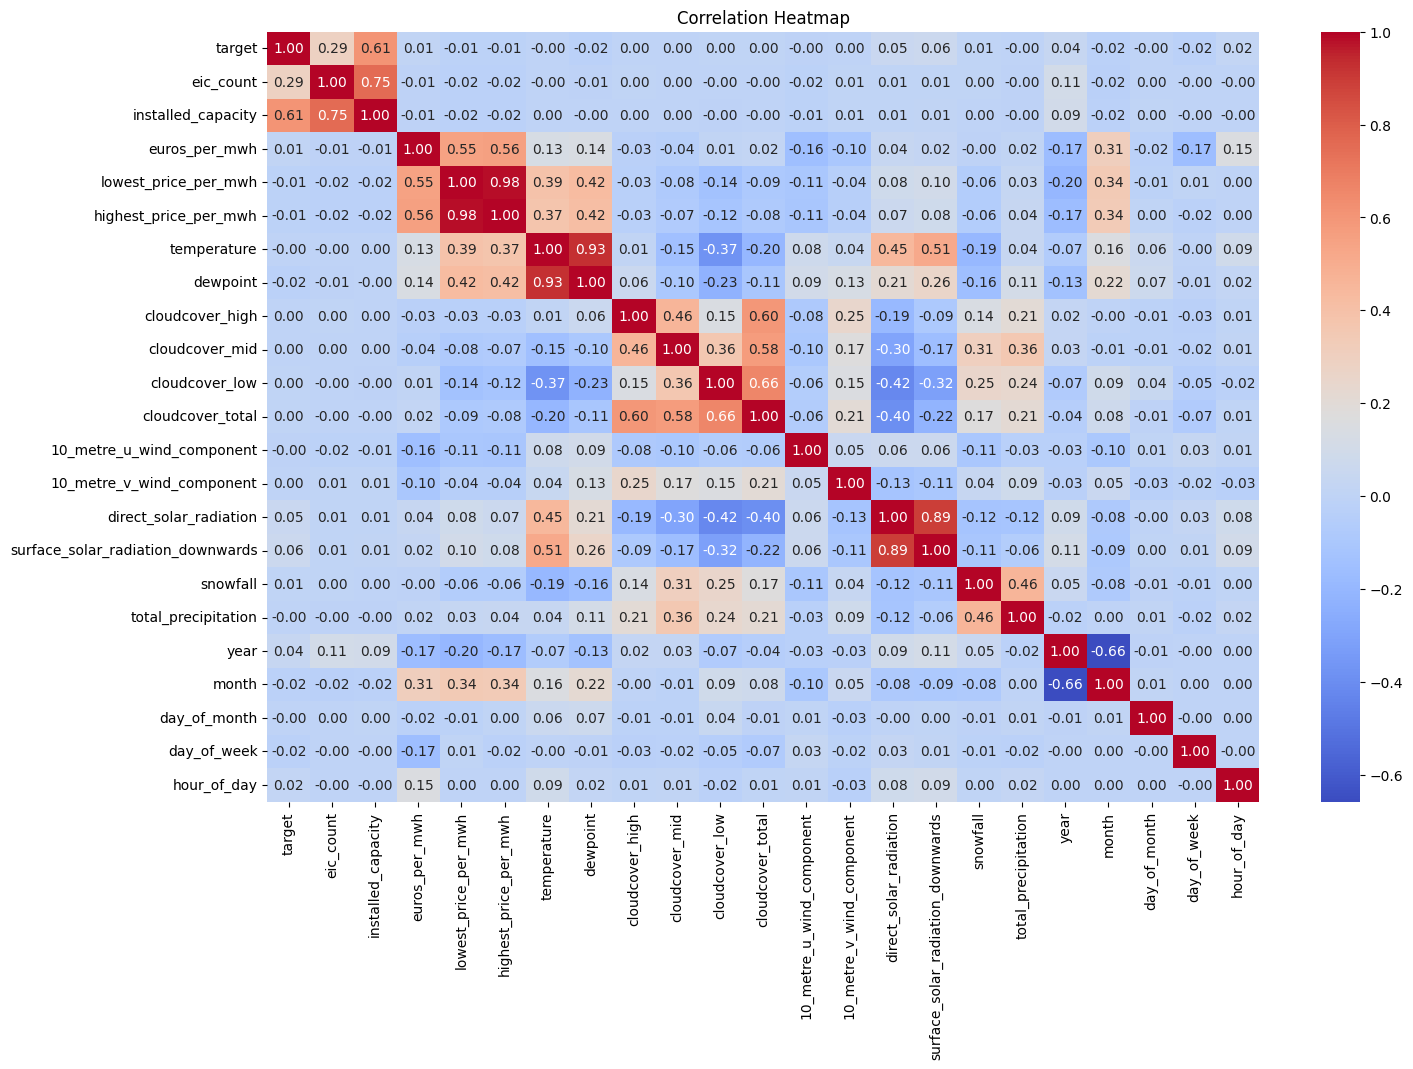

In [ ]:
numerical_cols = df.select_dtypes(include=[float, int]).columns
numerical_df = df[numerical_cols]
correlation_matrix = numerical_df.corr()

plt.figure(figsize=(16, 10))
plot = sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

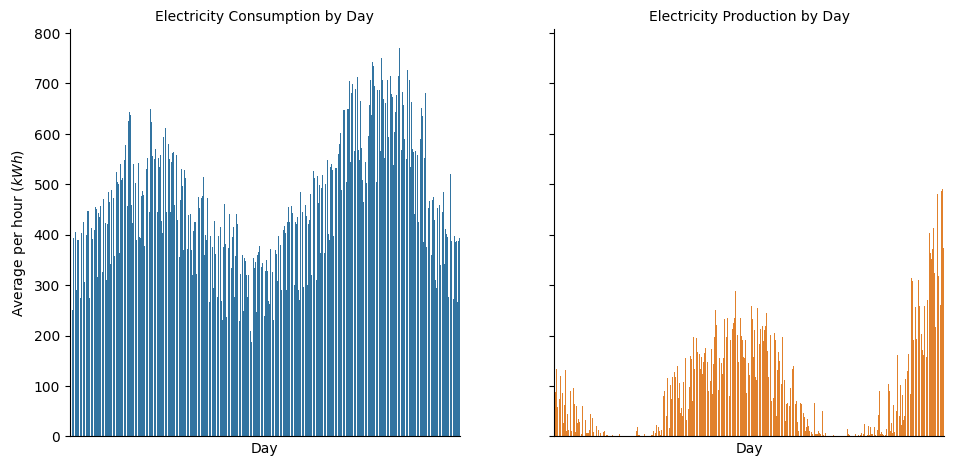

In [ ]:
plot = sns.catplot(data=df, x='date', y='target', hue='is_consumption', col='is_consumption', kind='bar', errorbar=None, legend=False)
plot.set_titles('Electricity {col_name} by Day')
plot.set_axis_labels('Day', r'Average per hour ($kWh$)')
plt.xticks([])
plt.show()

Clear seasonality with regard to the energy consumption and production amounts across the timespan of the data (637 days).

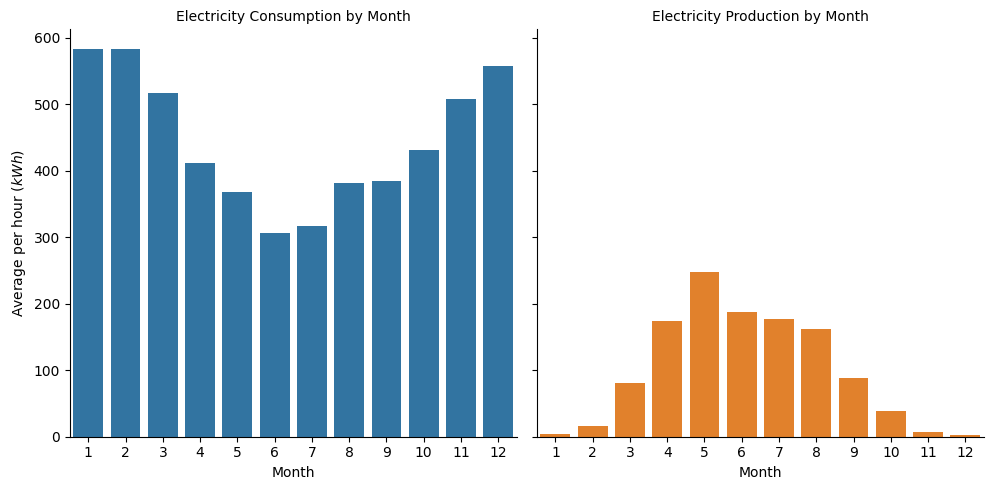

In [ ]:
plot = sns.catplot(data=df, x='month', y='target', hue='is_consumption', col='is_consumption', kind='bar', errorbar=None, legend=False)
plot.set_titles('Electricity {col_name} by Month')
plot.set_axis_labels('Month', 'Average per hour ($kWh$)')
plt.show()

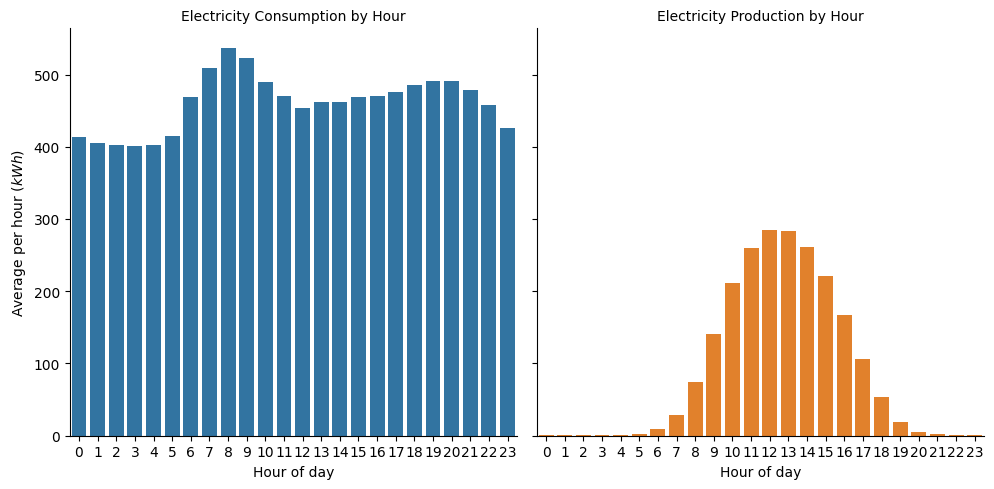

In [ ]:
plot = sns.catplot(data=df, x='hour_of_day', y='target', hue='is_consumption', col='is_consumption', kind='bar', errorbar=None, legend=False)
plot.set_titles('Electricity {col_name} by Hour')
plot.set_axis_labels('Hour of day', 'Average per hour ($kWh$)')
plt.show()

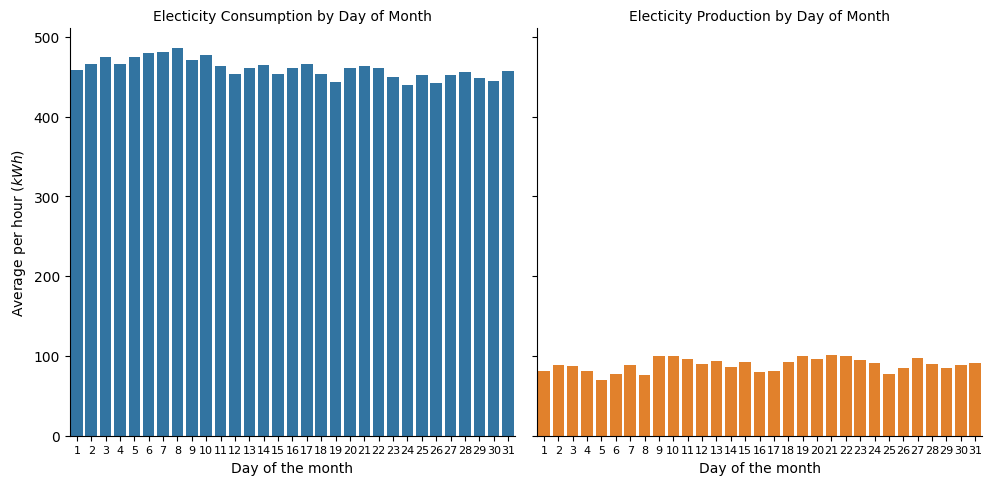

In [ ]:
plot = sns.catplot(data=df, x='day_of_month', y='target', hue='is_consumption', col='is_consumption', kind='bar', errorbar=None, legend=False)
plot.set_titles('Electicity {col_name} by Day of Month')
plot.set_axis_labels('Day of the month', 'Average per hour ($kWh$)')
plot.set_xticklabels(fontsize=8)
plt.show()

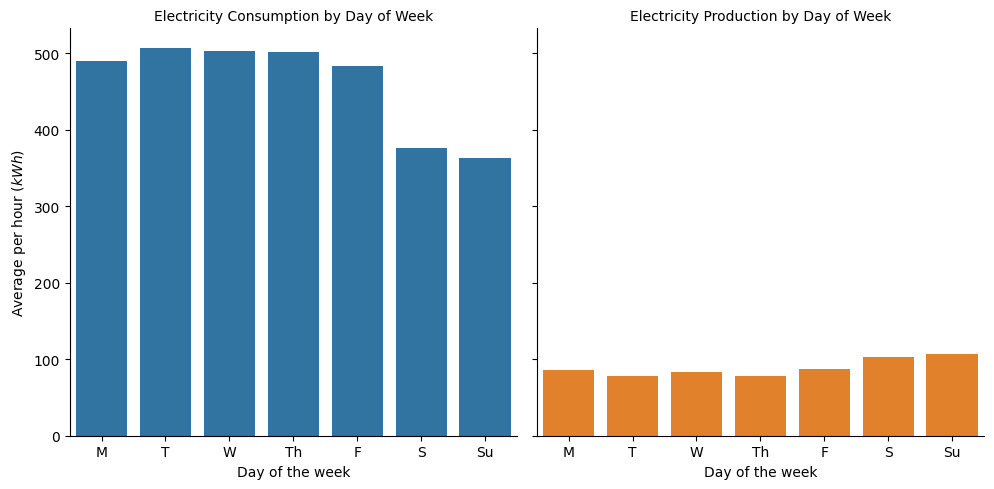

In [ ]:
day_labels = ['M', 'T', 'W', 'Th', 'F', 'S', 'Su']
plot = sns.catplot(data=df, x='day_of_week', y='target', hue='is_consumption', col='is_consumption', kind='bar', errorbar=None, legend=False)
plot.set_titles('Electricity {col_name} by Day of Week')
plot.set_axis_labels('Day of the week', 'Average per hour ($kWh$)')
for ax in plot.axes.flat:
    ax.set_xticks(range(7))
    ax.set_xticklabels(day_labels)
plt.show()

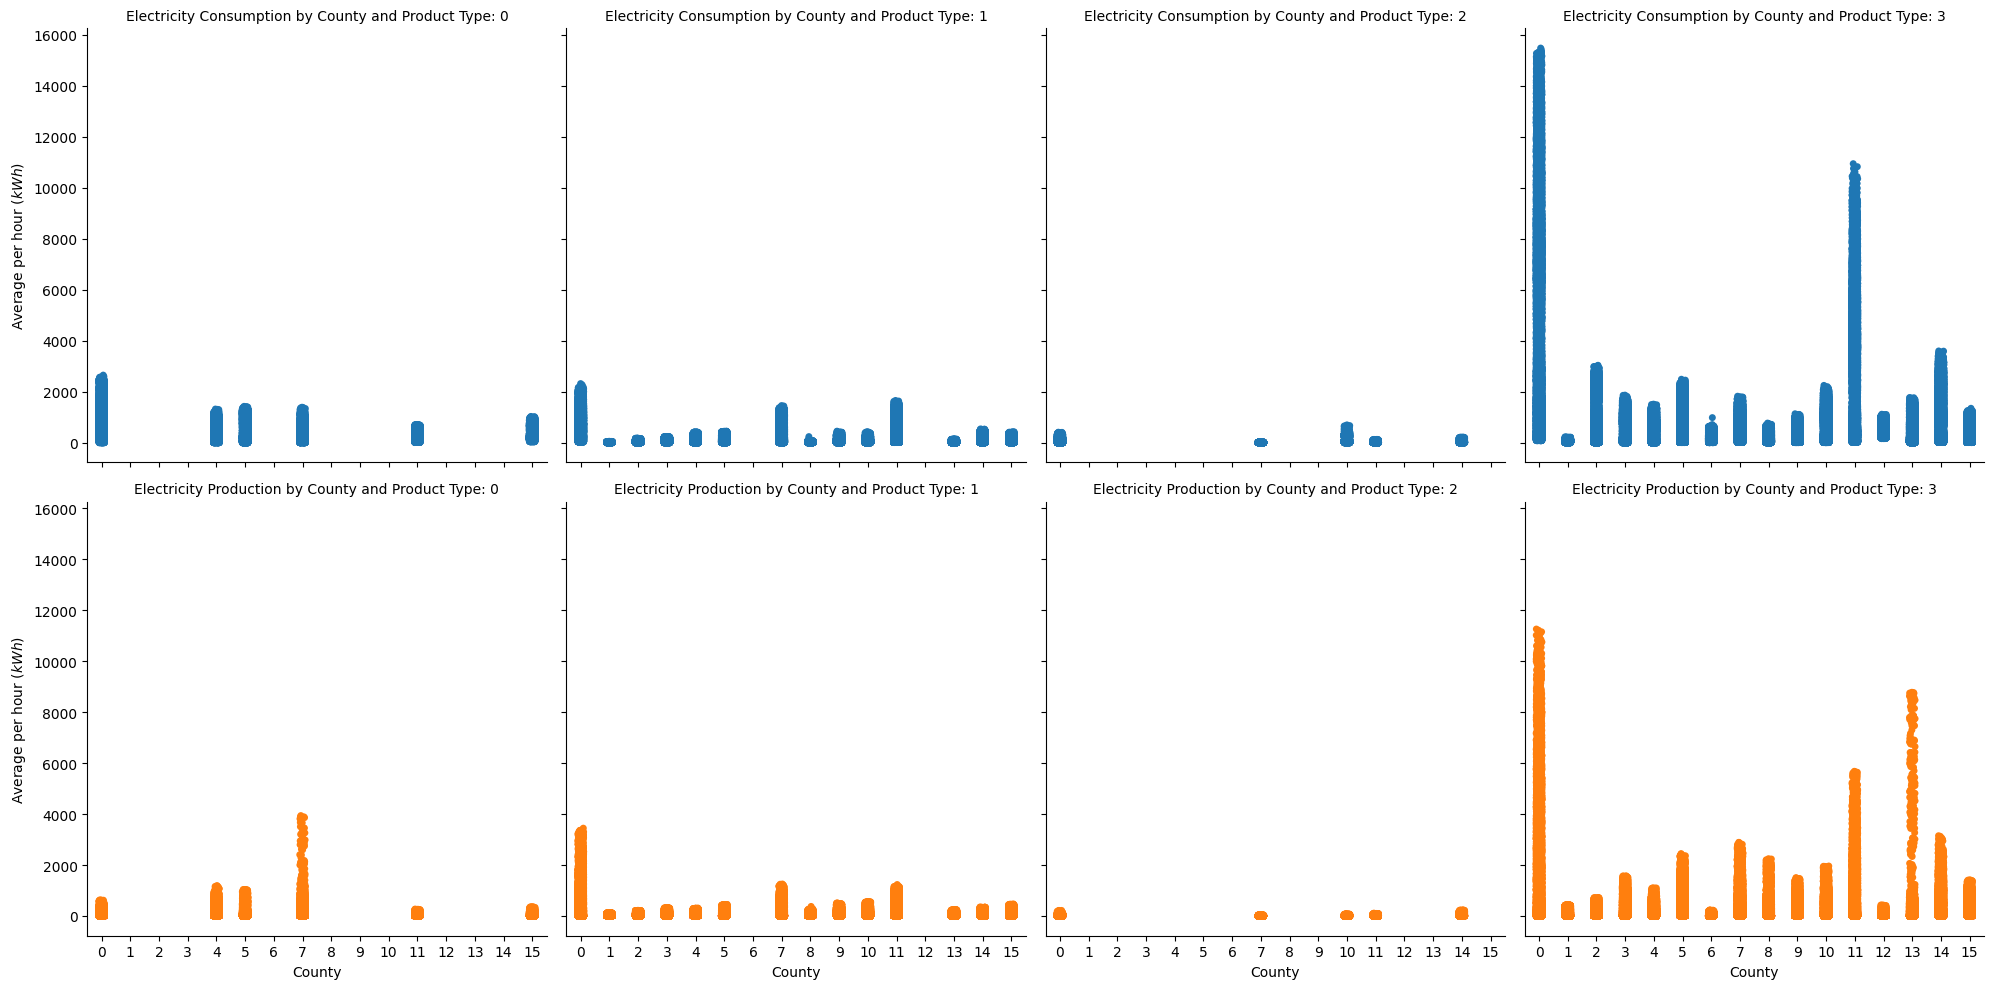

In [ ]:
plot = sns.catplot(data=df, x='county', y='target', row='is_consumption', hue='is_consumption', col='product_type', legend=False)
plot.set_titles('Electricity {row_name} by County and Product Type: {col_name}')
plot.set_axis_labels('County', 'Average per hour ($kWh$)')
plt.show()

The largest values of consumption/production are coming from only a few counties and one product type.

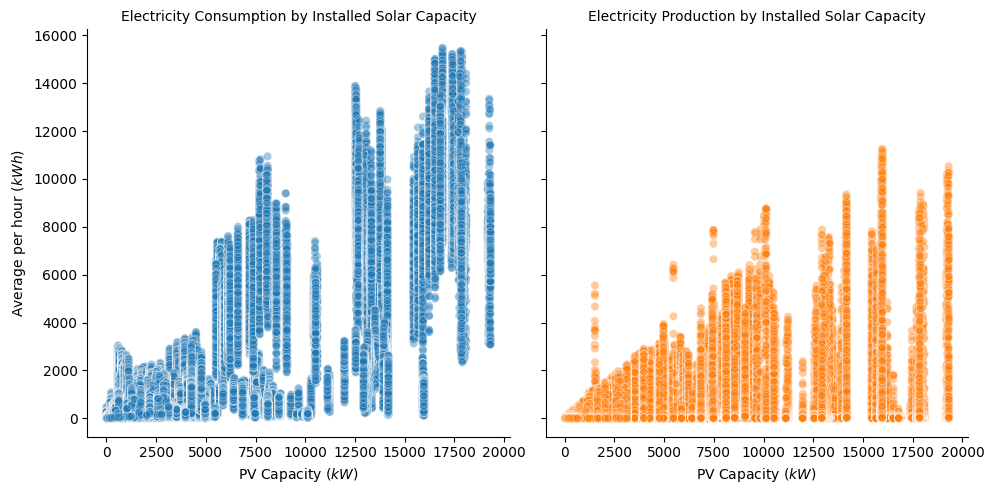

In [ ]:
# Takes 2 mins to create this plot
plot = sns.relplot(data=df, x='installed_capacity', y='target', col='is_consumption', hue='is_consumption', legend=False, alpha=0.4)
plot.set_titles('Electricity {col_name} by Installed Solar Capacity')
plot.set_axis_labels(r'PV Capacity ($kW$)', r'Average per hour ($kWh$)')
plt.show()

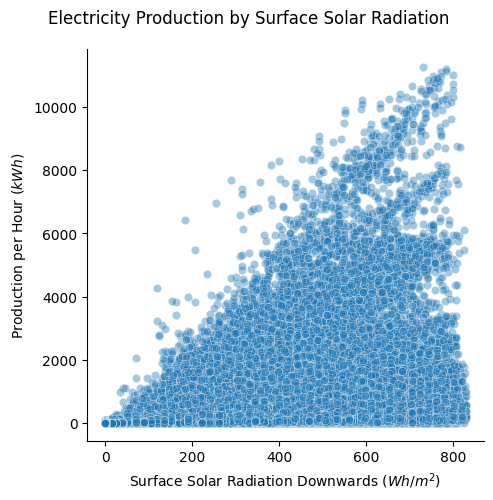

In [ ]:
plot = sns.relplot(data=df[df['is_consumption'] == 'Production'], x='surface_solar_radiation_downwards', y='target', alpha=0.4)
plot.figure.subplots_adjust(top=0.9);
plot.fig.suptitle('Electricity Production by Surface Solar Radiation')
plot.set_axis_labels(r'Surface Solar Radiation Downwards ($Wh / m^2$)', r'Production per Hour ($kWh$)')
plt.show()